In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

2022-08-18 21:15:05.792379: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TF_ENABLE_ONEDNN_OPTS=0

## test audio

In [3]:
import numpy as np
import IPython
T = 2.0    # seconds
sr = 22050  # sample rate
t = np.linspace(0, T, int(T*sr), endpoint=False)  # time variable
x = 0.5*np.sin(2*np.pi*440*t)                # pure sine wave at 440 Hz
IPython.display.Audio(x, rate=sr)


## initial

In [4]:
ori_data_path = '/D/TWCC/work/cgh_2022/data/use-three-ST-label-dataset_0401_0811/binear_classification/Backing/adult/'
npz_save_path = '/D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/'
SUBJET = 'adult'
if not os.path.exists(npz_save_path):
    os.makedirs(npz_save_path)
DATE = "0401_0811"
npz_name = 'Backing_0_1_data'+DATE+'_'+SUBJET

SEED = 42
KFOLD = True
K = 3

## make Dataset

In [4]:
classes=[]

def load_class():
    for _, dirs, _ in os.walk(os.path.abspath(ori_data_path)):
        break
    dirs = [int(x) for x in dirs]
    dirs.sort()
    dirs = [str(x) for x in dirs]
    return dirs

classes=load_class()
print(classes)

['0', '16']


In [5]:
filePaths = []
tmp_label = []
for n in classes:
    ori_path = ori_data_path + str(n)+'/'
    ori_n = 0
    for root2, _, files2 in os.walk(os.path.abspath(ori_path)):
        for file2 in files2:
            if('wav' in file2):
                filePaths.append(os.path.join(root2, file2))
                tmp_label.append(int(n))
                ori_n = ori_n+1
    print('Class: ', n, ' files: ',ori_n)
# random.Random(SEED).shuffle(file_path)  # 把tmp_list弄亂


Class:  0  files:  476
Class:  16  files:  839


In [8]:
import librosa
wav_data = []
fix_n_sec = 2
mini_sec = 0.3
wav_label = []
for i, filePath in enumerate(filePaths):
    try:
        y, sr = librosa.load(filePath,sr =16000)
    except:
        print("read error: ", filePath)
    if len(y)<=0:
        break;
    if len(y)/sr < mini_sec:
        print('len < '+mini_sec+': ', filePath)
        break;
    if len(y)/sr > fix_n_sec:  # pad if len less 1 sec
        x = y[:fix_n_sec * sr]
    elif mini_sec < len(y)/sr < fix_n_sec :
        z = int(fix_n_sec*sr - len(y))
        if(z%2==0):
            z1 = int(z/2)
            z2 = int(z/2)
        else:
            z1 = int((z-1)/2)
            z2 = int(z1 + 1)
        try:
            x = np.pad(y,(z1,z2), 'linear_ramp', end_values=(0, 0))
        except:
            print("pad error: ", filePath)
    
    wav_data.append(x)
    wav_label.append(tmp_label[i])
X = np.asarray(wav_data)
y = np.asarray(wav_label)


In [9]:
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")


X.shape: (1315, 32000)
y.shape: (1315,)


In [10]:
y

array([ 0,  0,  0, ..., 16, 16, 16])

In [11]:
from IPython.display import Audio

Audio(X[1], rate=sr)


In [12]:
if (KFOLD):
    # example of stratified k-fold cross-validation with an imbalanced dataset
    from sklearn.datasets import make_classification
    from sklearn.model_selection import StratifiedKFold
    # generate 2 class dataset
    kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
    # enumerate the splits and summarize the distributions
    i = 1
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # summarize train and test composition
        train_0, train_16 = len(y_train[y_train == 0]), len(y_train[y_train == 16])
        test_0, test_16 = len(y_test[y_test == 0]), len(y_test[y_test == 16])
        print(f"part{i}:")
        print('>Train: 0=%d, 16=%d, Test: 0=%d, 16=%d' %
              (train_0, train_16, test_0, test_16))
        print(f"saving {npz_save_path+npz_name}_part_{i}")
        np.savez(
            npz_save_path+npz_name+"_part_"+str(i),
            X_train=np.asarray(X_train),
            y_train=np.asarray(y_train),
            X_test=np.asarray(X_test),
            y_test=np.asarray(y_test)
        )        
        i = i + 1
else:  
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y)
    classes = np.unique(y_train)
    train_0, train_16 = len(y_train[y_train == 0]), len(y_train[y_train == 16])
    test_0, test_16 = len(y_test[y_test == 0]), len(y_test[y_test == 16])
    print('>Train: 0=%d, 16=%d, Test: 0=%d, 16=%d' %
          (train_0, train_16, test_0, test_16))
    print(f"saving {npz_save_path+npz_name}")
    np.savez(
        npz_save_path+npz_name,
        X_train=np.asarray(X_train),
        y_train=np.asarray(y_train),
        X_test=np.asarray(X_test),
        y_test=np.asarray(y_test)
    )
    

part1:
>Train: 0=317, 16=559, Test: 0=159, 16=280
saving /D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0811_part_1
part2:
>Train: 0=317, 16=560, Test: 0=159, 16=279
saving /D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0811_part_2
part3:
>Train: 0=318, 16=559, Test: 0=158, 16=280
saving /D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0811_part_3


# train


In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import sys
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import mixed_precision
from IPython.display import Audio
import librosa
from sklearn.metrics import confusion_matrix



2022-08-18 21:49:02.661318: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TF_ENABLE_ONEDNN_OPTS=0

In [3]:
# list_a = ['1','2','3']
# for i in list_a:
#     ADULTPATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0811_adult_part_'+i+'.npz'
#     KIDPATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0707_part_'+i+'.npz'
#     x_adult = np.load(ADULTPATH, mmap_mode='r', allow_pickle=True)
#     Xadult_train = x_adult['X_train']
#     yadult_train = x_adult['y_train']
#     Xadult_test = x_adult['X_test']
#     yadult_test = x_adult['y_test']
#     x_child = np.load(KIDPATH, mmap_mode='r', allow_pickle=True)
#     Xchild_train = x_child['X_train']
#     ychild_train = x_child['y_train']
#     Xchild_test = x_child['X_test']
#     ychild_test = x_child['y_test']
#     X_train = np.concatenate((Xadult_train, Xchild_train, Xadult_test), axis=0)
#     y_train = np.concatenate((yadult_train, ychild_train, yadult_test), axis=0)
#     X_test = Xchild_test
#     y_test = ychild_test
#     npz_name = 'Backing_0_1_data'+DATE+'_'+'mix'
#     np.savez(
#         npz_save_path+npz_name+"_part_"+str(i),
#         X_train=np.asarray(X_train),
#         y_train=np.asarray(y_train),
#         X_test=np.asarray(X_test),
#         y_test=np.asarray(y_test)
#     )


In [4]:
sr = 16000
part = '1'
NPDATA_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0811_mix_part_'+part+'.npz'
SEED = 42
def plot_time_series(data, sr):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, len(data)/sr, len(data)), data)
    plt.show()


In [5]:
x = np.load(NPDATA_PATH, mmap_mode='r', allow_pickle=True)
X_train = x['X_train']
y_train = x['y_train']
X_test = x['X_test']
y_test = x['y_test']

In [6]:
classes = np.unique(y_train)
total = len(y_train)
for c in classes:
	n_examples = len(y_train[y_train == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')

> Class=0 : 590/1830 32.240437158469945%
> Class=16 : 1240/1830 67.75956284153006%


In [7]:
classes = np.unique(y_test)
total = len(y_test)
for c in classes:
	n_examples = len(y_test[y_test == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 57/258 22.093023255813954%
> Class=16 : 201/258 77.90697674418605%


## change class

In [8]:
for c in classes:
    if c == 0:
        y_train[y_train == c] = 1 
        y_test[y_test == c] = 1 
    elif c == 16:
        y_train[y_train == c] = 0
        y_test[y_test == c] = 0

In [9]:
classes = np.unique(y_train)
total = len(y_train)
print(f"training")
for c in classes:
    n_examples = len(y_train[y_train == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


training
> Class=0 : 1240/1830 67.75956284153006%
> Class=1 : 590/1830 32.240437158469945%


In [10]:
classes = np.unique(y_test)
total = len(y_test)
print(f"testing")
for c in classes:
    n_examples = len(y_test[y_test == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


testing
> Class=0 : 201/258 77.90697674418605%
> Class=1 : 57/258 22.093023255813954%


## data augmentation

In [11]:
# minority_data = X_train[y_train == 1]
# minority_label = y_train[y_train == 1]
minority_data = X_train
minority_label = y_train


In [12]:
minority_data.shape


(1830, 32000)

In [13]:
minority_label.shape


(1830,)

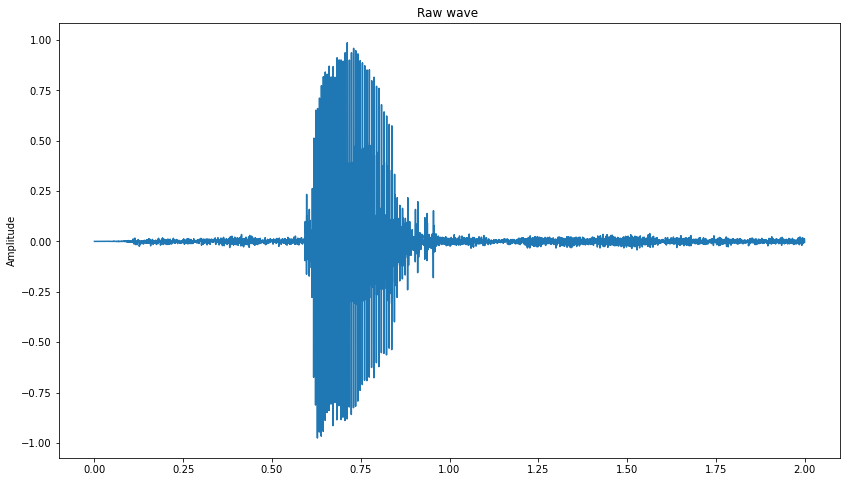

In [14]:
plot_time_series(minority_data[0], sr)
Audio(minority_data[0], rate=sr)

In [15]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment1 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
augment2 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    TimeStretch(min_rate=0.8, max_rate=1.25, p=1)
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

augment3 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    PitchShift(min_semitones=-4, max_semitones=4, p=1),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=1)
])

augment4 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)
])

# Generate 2 seconds of dummy audio for the sake of example
# samples = np.random.uniform(
#     low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_sample1 = augment1(samples=minority_data, sample_rate=sr)
augmented_sample2 = augment2(samples=minority_data, sample_rate=sr)
augmented_sample3 = augment3(samples=minority_data, sample_rate=sr)
augmented_sample4 = augment4(samples=minority_data, sample_rate=sr)


In [16]:
print(f"augmented_sample1.shape: {augmented_sample1.shape}")
print(f"augmented_sample2.shape: {augmented_sample2.shape}")
print(f"augmented_sample3.shape: {augmented_sample3.shape}")
print(f"augmented_sample4.shape: {augmented_sample4.shape}")


augmented_sample1.shape: (1830, 32000)
augmented_sample2.shape: (1830, 32000)
augmented_sample3.shape: (1830, 32000)
augmented_sample4.shape: (1830, 32000)


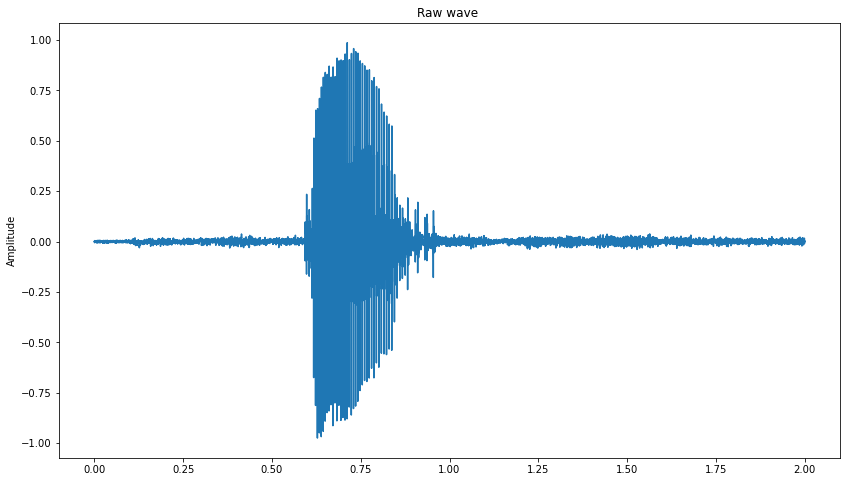

In [17]:
Audio(augmented_sample1[0], rate=sr)
plot_time_series(augmented_sample1[0], sr)



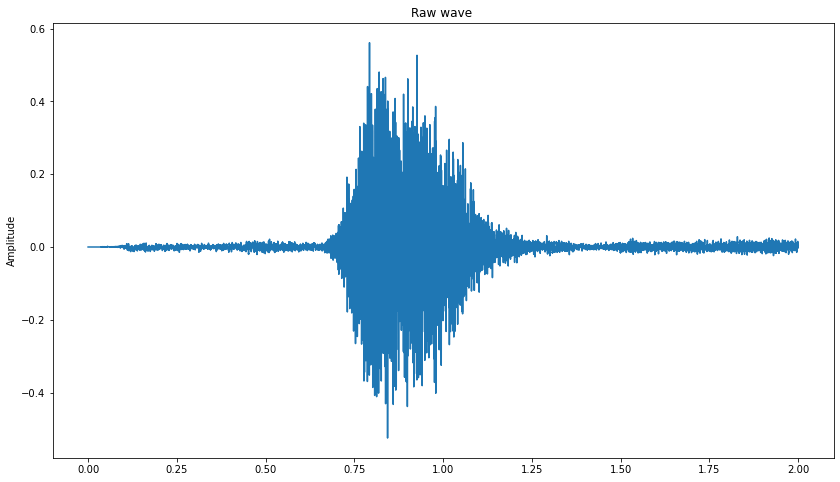

In [18]:
plot_time_series(augmented_sample2[0], sr)
Audio(augmented_sample2[0], rate=sr)

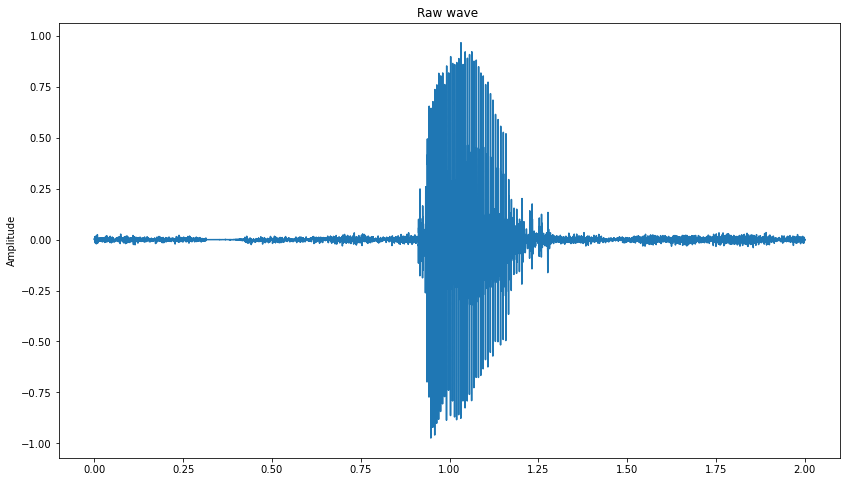

In [19]:
plot_time_series(augmented_sample3[0], sr)
Audio(augmented_sample3[0], rate=sr)

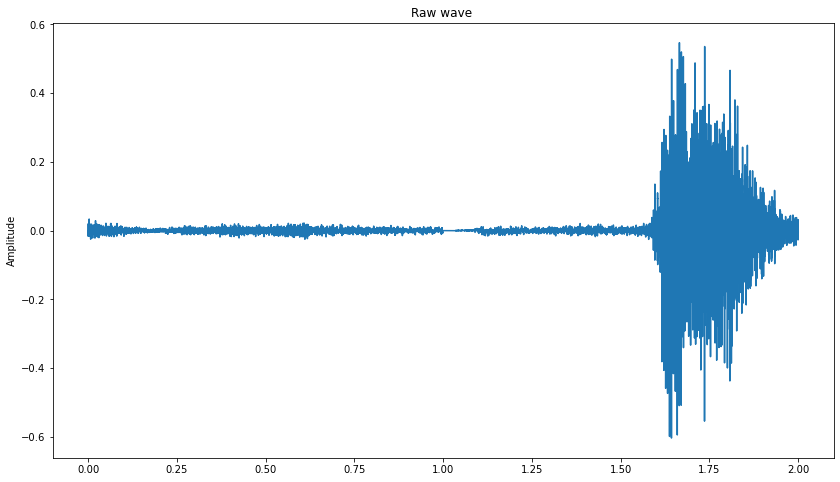

In [20]:
plot_time_series(augmented_sample4[0], sr)
Audio(augmented_sample4[0], rate=sr)

In [21]:
X_train = np.concatenate(
    [X_train, augmented_sample1, augmented_sample2, augmented_sample3, augmented_sample4], axis=0)
y_train = np.concatenate(
    [y_train, minority_label, minority_label, minority_label, minority_label], axis=0)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")



X_train.shape: (9150, 32000)
y_train.shape: (9150,)


## Random train

In [22]:
order = np.arange(len(y_train))
np.random.seed(SEED)
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
X_train.shape


(9150, 32000)

## processing

In [23]:
from skimage.transform import resize
def get_3ch_spectrum(wav,sr):
    feature_size = 128
    num_channels = 3
    window_sizes = [25, 50, 100]
    hop_sizes = [10, 25, 50]
    normalizedy = librosa.util.normalize(wav)
    specs = []
    for i in range(num_channels):
        window_length = int(round(window_sizes[i]*sr/1000))
        # print('win_len: ',window_length)
        hop_length = int(round(hop_sizes[i]*sr/1000))
        mel = librosa.feature.melspectrogram(
            y=normalizedy, sr=sr, n_fft=4410, hop_length=hop_length, win_length=window_length, n_mels=128)
        mellog = np.log(mel + 1e-6)
        # print(mellog)
        # spec = librosa.util.normalize(mellog)
        spec = resize(mellog, (128, feature_size))
        spec = np.asarray(spec)
        specs.append(spec)
    # list to np array
    specs = np.asarray(specs)
    specs = np.moveaxis(specs, 0, 2)
#     print('specs.shape : ', specs.shape)
    return specs




In [24]:
train_specs = []
for i in range (X_train.shape[0]):
    spec = get_3ch_spectrum(X_train[i],sr)
    train_specs.append(spec)
X_train = np.asarray(train_specs)

In [25]:
test_specs = []
for i in range (X_test.shape[0]):
    spec = get_3ch_spectrum(X_test[i],sr)
    test_specs.append(spec)
X_test = np.asarray(test_specs)

## model

In [26]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import tensorflow as tf
import datetime
import tempfile


In [27]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


## Define the model and metrics

In [28]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
      if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
      base_model = tf.keras.applications.EfficientNetV2B0(
          include_top=False,
          weights="imagenet",
          input_shape=(128, 128, 3),
      )
      base_model.trainable = True
      inputs = keras.Input(shape=(128, 128, 3))
      inputs = keras.layers.BatchNormalization()(inputs)
      x = base_model(inputs, training=True)
      x = keras.layers.GlobalAveragePooling2D()(x)
      x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
      x = keras.layers.Dense(512, activation='relu')(x)
      outputs = keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
      model = keras.Model(inputs, outputs)
      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=1e-3),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=METRICS)
      return model


2022-08-18 21:52:48.018505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:52:48.025926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:52:48.026024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:52:48.026433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

### Baseline model

In [29]:
EPOCHS = 50
BATCH_SIZE = 32
SAVE_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/'
model_name = 'EfficientNetV2B0'
output_bias = None
dataset = 'Backing-mix-baseline'
NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+part+'_' + \
    datetime.datetime.now().strftime("%m%d_%H%M")
log_dir = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/logs/' + NAME


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_ckpt = ModelCheckpoint(
            SAVE_PATH + NAME +
            '_{epoch:02d}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
            monitor='val_recall',
            mode='max',
            save_freq='epoch',
            verbose=2, 
            save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max', verbose=1, restore_best_weights=True, patience=10)
model = make_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 1)                 513   

In [31]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


### Train the model

In [32]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        model_ckpt,
        es
    ],
    validation_data=(X_test, y_test))


Epoch 1/50


2022-08-18 21:52:56.642666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-18 21:52:56.793539: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-18 21:52:56.794302: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-18 21:52:56.794320: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-18 21:52:56.794984: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-18 21:52:56.795034: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


286/286 [==============================] - ETA: 0s - loss: 0.4365 - tp: 1806.0000 - fp: 643.0000 - tn: 5557.0000 - fn: 1144.0000 - accuracy: 0.8047 - precision: 0.7374 - recall: 0.6122 - auc: 0.8550 - prc: 0.7511
Epoch 1: val_recall improved from -inf to 0.33333, saving model to /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/EfficientNetV2B0_Backing-mix-baseline_bs32_data_part1_0818_2152_01-0.27-0.33.hdf5
286/286 [==============================] - 24s 65ms/step - loss: 0.4365 - tp: 1806.0000 - fp: 643.0000 - tn: 5557.0000 - fn: 1144.0000 - accuracy: 0.8047 - precision: 0.7374 - recall: 0.6122 - auc: 0.8550 - prc: 0.7511 - val_loss: 0.8561 - val_tp: 19.0000 - val_fp: 51.0000 - val_tn: 150.0000 - val_fn: 38.0000 - val_accuracy: 0.6550 - val_precision: 0.2714 - val_recall: 0.3333 - val_auc: 0.5646 - val_prc: 0.2561
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 0.2353 - tp: 2477.0000 - fp: 373.0000 - tn: 5827.0000 - fn: 473.0000 - accu

### Check training history

In [33]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

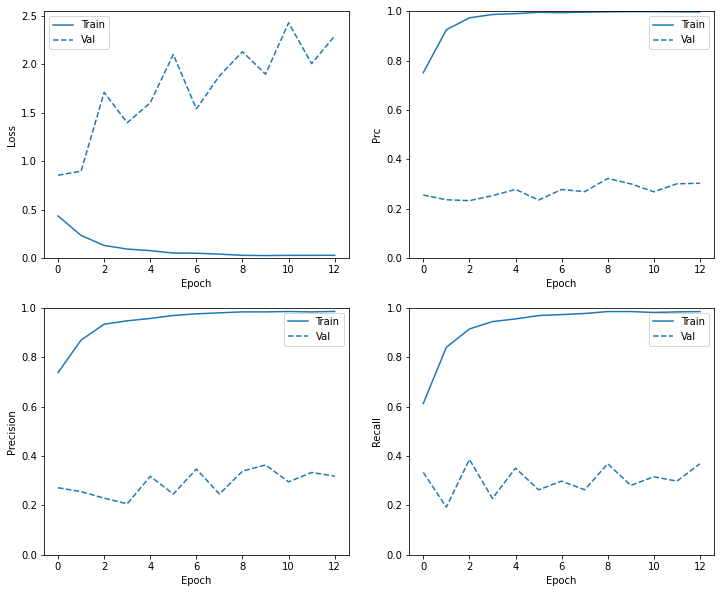

In [34]:
plot_metrics(baseline_history)

### Evaluate metrics


In [35]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

9/9 [==============================] - 0s 14ms/step


In [36]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  1.6896096467971802
tp :  23.0
fp :  64.0
tn :  137.0
fn :  34.0
accuracy :  0.6201550364494324
precision :  0.26436781883239746
recall :  0.4035087823867798
auc :  0.5313782095909119
prc :  0.24551647901535034

Legitimate Transactions Detected (True Negatives):  131
Legitimate Transactions Incorrectly Detected (False Positives):  70
Fraudulent Transactions Missed (False Negatives):  37
Fraudulent Transactions Detected (True Positives):  20
Total Fraudulent Transactions:  57


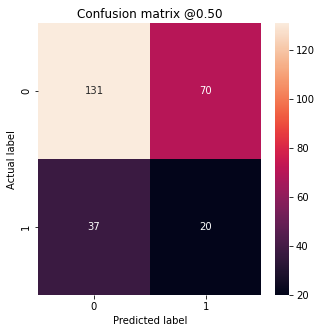

In [37]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

### Plot the ROC


In [38]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

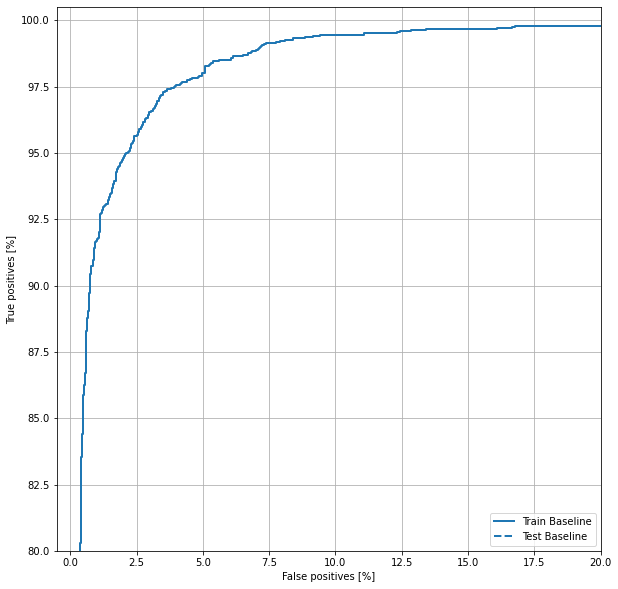

In [39]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

In [40]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

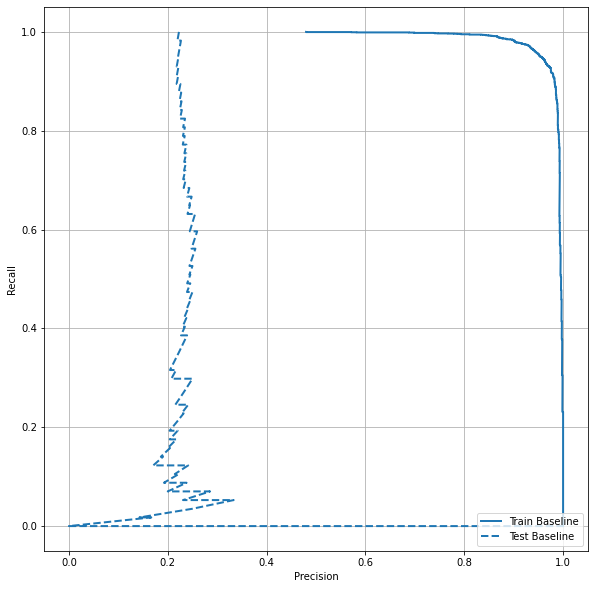

In [41]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

# class_weight

In [42]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 9150
    Positive: 2950 (32.24% of total)



In [43]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.74
Weight for class 1: 1.55


In [44]:
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [45]:
EPOCHS = 50
BATCH_SIZE = 32
SAVE_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/'
model_name = 'EfficientNetV2B0'
dataset = 'Backing-mix-weighted'
NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+part+'_' + \
    datetime.datetime.now().strftime("%m%d_%H%M")

log_dir = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/logs/' + NAME



In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


model_ckpt = ModelCheckpoint(
    SAVE_PATH + NAME +
    '_{epoch:02d}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    monitor='val_recall',
    mode='max',
    save_freq='epoch',
    verbose=2,
    save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max',
                   verbose=1, restore_best_weights=True, patience=10)


In [47]:
weighted_model = make_model(output_bias)
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        model_ckpt,
        es
    ],
    validation_data=(X_test, y_test),
    # The class weights go here
    class_weight=class_weight)


Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 0.4766 - tp: 2280.0000 - fp: 1402.0000 - tn: 4999.0000 - fn: 727.0000 - accuracy: 0.7737 - precision: 0.6192 - recall: 0.7582 - auc: 0.8456 - prc: 0.7152
Epoch 1: val_recall improved from -inf to 0.40351, saving model to /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/EfficientNetV2B0_Backing-mix-weighted_bs32_data_part1_0818_2156_01-0.28-0.40.hdf5
286/286 [==============================] - 23s 64ms/step - loss: 0.4766 - tp: 2280.0000 - fp: 1402.0000 - tn: 4999.0000 - fn: 727.0000 - accuracy: 0.7737 - precision: 0.6192 - recall: 0.7582 - auc: 0.8456 - prc: 0.7152 - val_loss: 0.8374 - val_tp: 23.0000 - val_fp: 59.0000 - val_tn: 142.0000 - val_fn: 34.0000 - val_accuracy: 0.6395 - val_precision: 0.2805 - val_recall: 0.4035 - val_auc: 0.5441 - val_prc: 0.2487
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 0.2641 - tp: 2634.0000 - fp: 704.0000 - tn: 5496.0000 - fn: 316.

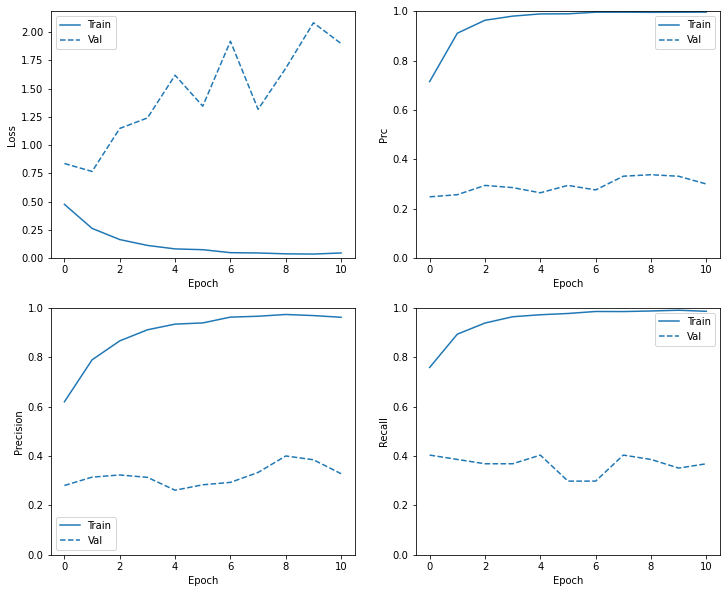

In [48]:
plot_metrics(weighted_history)

In [49]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

9/9 [==============================] - 0s 13ms/step


loss :  0.8329734802246094
tp :  25.0
fp :  58.0
tn :  143.0
fn :  32.0
accuracy :  0.6511628031730652
precision :  0.3012048304080963
recall :  0.4385964870452881
auc :  0.5428559184074402
prc :  0.2444506138563156

Legitimate Transactions Detected (True Negatives):  147
Legitimate Transactions Incorrectly Detected (False Positives):  54
Fraudulent Transactions Missed (False Negatives):  33
Fraudulent Transactions Detected (True Positives):  24
Total Fraudulent Transactions:  57


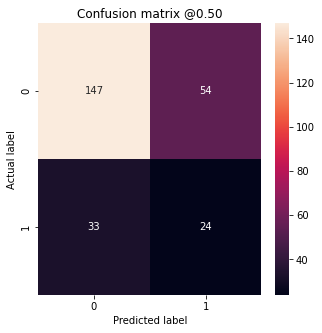

In [50]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

### Plot the ROC

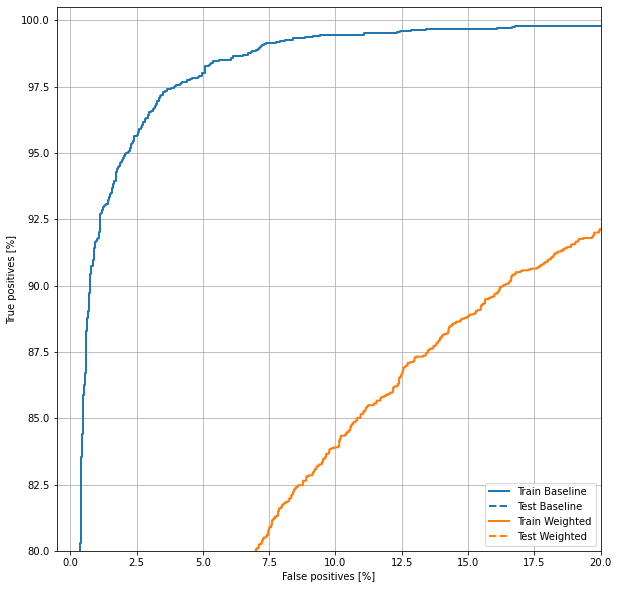

In [51]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')


plt.legend(loc='lower right');


plt.legend(loc='lower right');

### Plot the AUPRC

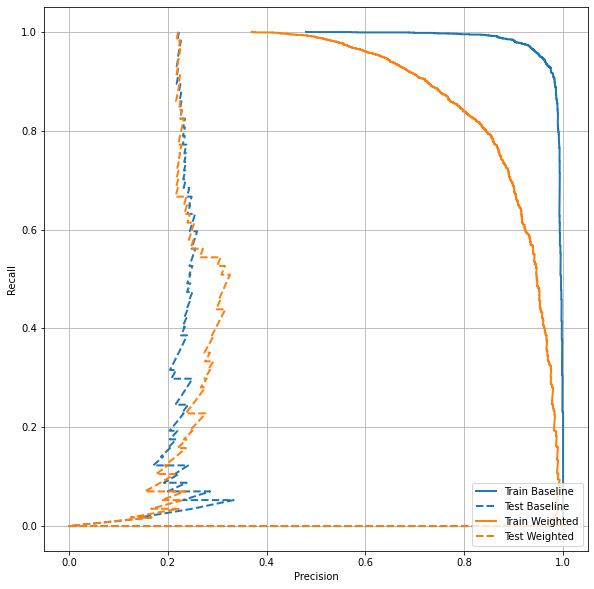

In [52]:
plot_prc("Train Baseline", y_train,
         train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train,
         train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')


plt.legend(loc='lower right')


## Oversampling

In [53]:
bool_train_labels = y_train != 0


In [54]:
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]


In [55]:
pos_features.shape

(2950, 128, 128, 3)

In [56]:
neg_features.shape

(6200, 128, 128, 3)

In [57]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape


(6200, 128, 128, 3)

In [58]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape


(12400, 128, 128, 3)

In [59]:
BUFFER_SIZE = 100000


def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))  # .cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds


pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


In [60]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())


Features:
 [[[-1.0801474e+00 -5.1004156e-02  3.9647412e-01]
  [-6.2412733e-01 -1.0759563e-01  7.1324718e-01]
  [-9.2124510e-01 -2.9745197e-01  4.3510497e-01]
  ...
  [-1.9785265e+00 -5.1049989e-01  7.9729311e-02]
  [-9.8732591e-01 -6.1788100e-01  1.1420936e-01]
  [-9.6469402e-01 -6.8784350e-01  7.4940421e-02]]

 [[-1.0831065e+00 -4.9290058e-01  4.5988321e-01]
  [ 7.4851578e-01 -4.6080926e-01  2.5089270e-01]
  [ 2.6950264e-01 -3.3855626e-01  4.3439656e-01]
  ...
  [ 5.3132144e-03 -1.1680070e+00 -4.5052212e-01]
  [ 6.1028743e-01 -1.0063609e+00 -3.8256982e-01]
  [ 9.3443274e-02 -9.3795478e-01 -4.5995992e-01]]

 [[ 5.1481288e-02  6.4285183e-01  7.1399105e-01]
  [ 1.7998817e+00  1.0613844e+00  5.5983716e-01]
  [ 1.5660709e+00  1.9100201e+00  6.9519180e-01]
  ...
  [ 1.6419140e+00  1.8678292e+00  1.2056305e+00]
  [ 1.7370721e+00  1.6402924e+00  1.1959738e+00]
  [ 1.2216367e+00  1.5296698e+00  1.2069718e+00]]

 ...

 [[-6.7992539e+00 -6.6273370e+00 -7.5324583e+00]
  [-1.1708609e+01 -8.3015079

In [61]:
resampled_ds = tf.data.Dataset.sample_from_datasets(
    [pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)


In [62]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())


0.65625


In [63]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch


388.0

In [64]:
EPOCHS = 50
BATCH_SIZE = 32
SAVE_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/'
model_name = 'EfficientNetV2B0'
output_bias = None
dataset = 'Backing-mix-oversampling'
NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+part+'_' + \
    datetime.datetime.now().strftime("%m%d_%H%M")
log_dir = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/logs/' + NAME


In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_ckpt = ModelCheckpoint(
    SAVE_PATH + NAME +
    '_{epoch:02d}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    monitor='val_recall',
    mode='max',
    save_freq='epoch',
    verbose=2,
    save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max',
                   verbose=1, restore_best_weights=True, patience=10)


In [66]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        model_ckpt,
        es
    ],
    validation_data=val_ds)


Epoch 1/50
388/388 [==============================] - ETA: 0s - loss: 0.4053 - tp: 5165.0000 - fp: 1286.0000 - tn: 5090.0000 - fn: 1133.0000 - accuracy: 0.8091 - precision: 0.8007 - recall: 0.8201 - auc: 0.8933 - prc: 0.8836
Epoch 1: val_recall improved from -inf to 0.59649, saving model to /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/EfficientNetV2B0_Backing-mix-oversampling_bs32_data_part1_0818_2200_01-0.27-0.60.hdf5
388/388 [==============================] - 28s 62ms/step - loss: 0.4053 - tp: 5165.0000 - fp: 1286.0000 - tn: 5090.0000 - fn: 1133.0000 - accuracy: 0.8091 - precision: 0.8007 - recall: 0.8201 - auc: 0.8933 - prc: 0.8836 - val_loss: 1.4375 - val_tp: 34.0000 - val_fp: 90.0000 - val_tn: 111.0000 - val_fn: 23.0000 - val_accuracy: 0.5620 - val_precision: 0.2742 - val_recall: 0.5965 - val_auc: 0.5616 - val_prc: 0.2722
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 0.1851 - tp: 5798.0000 - fp: 506.0000 - tn: 5732.0000 - fn

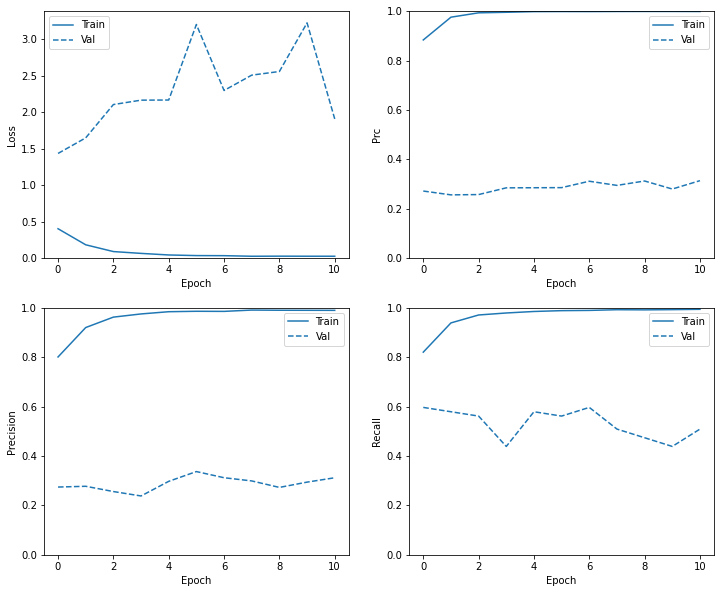

In [67]:
plot_metrics(resampled_history)


In [68]:
train_predictions_resampled = resampled_model.predict(
    X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(
    X_test, batch_size=BATCH_SIZE)


9/9 [==============================] - 0s 14ms/step


loss :  1.4690306186676025
tp :  33.0
fp :  89.0
tn :  112.0
fn :  24.0
accuracy :  0.5620155334472656
precision :  0.2704918086528778
recall :  0.5789473652839661
auc :  0.5611853003501892
prc :  0.26750653982162476

Legitimate Transactions Detected (True Negatives):  109
Legitimate Transactions Incorrectly Detected (False Positives):  92
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  33
Total Fraudulent Transactions:  57


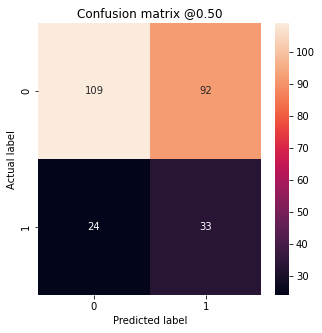

In [69]:
resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)


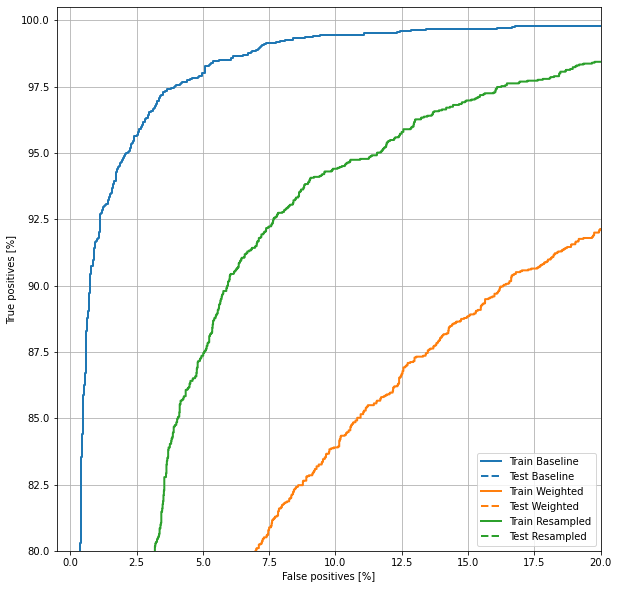

In [70]:
plot_roc("Train Baseline", y_train,
         train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train,
         train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train,
         train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,
         color=colors[2], linestyle='--')
plt.legend(loc='lower right')


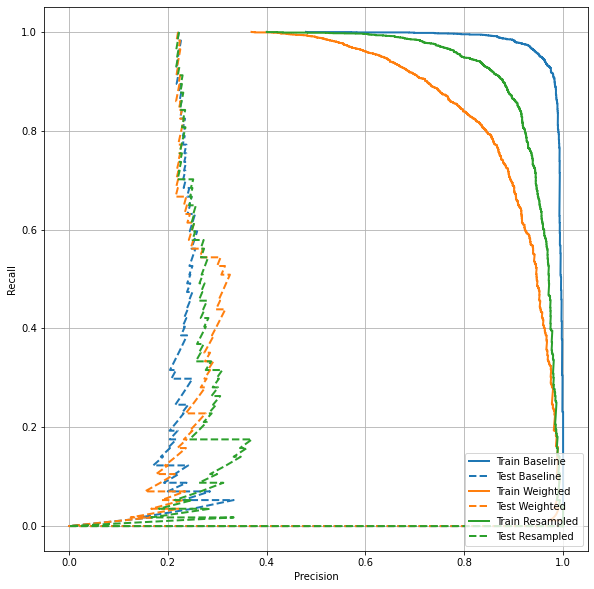

In [71]:
plot_prc("Train Baseline", y_train,
         train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline,
         color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train,
         train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted,
         color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train,
         train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test, test_predictions_resampled,
         color=colors[2], linestyle='--')
plt.legend(loc='lower right')
